In [3]:
%run flow_tools.py

In [4]:
folders = [box_dir + 'BadIdea/Flow/20210406 - 24hr/',
           box_dir + 'BadIdea/Flow/20210407 - 48hr/',
           box_dir + 'BadIdea/Flow/20210408 - 72hr/']

In [5]:
df = pd.concat([load_data(folder, colnames = ["WellName", "Sender", "Receiver",
                                              'Ratio','Timepoint','Replicate'])
               for folder in folders])
df2 = clean_data(df)

In [6]:
# calculate actual ratio of receivers to sender, not just the predicted ratio.
def get_density(dist, model, k562_component):
    ids = model.predict(dist.values[:,np.newaxis])
    k562_ratio = np.sum(ids==k562_component)/np.sum(ids!=k562_component)
    return k562_ratio

sentinel_filter = ((df2.Receiver == 'No Notch') &
                   (df2.Sender == 'None'))
k562_filter = ((df2.Receiver == 'None') &
               (df2.Sender == 'K562'))
joint_dist = df2[sentinel_filter | k562_filter]['logFITC-A'].values[:,np.newaxis]
celltype_model = GaussianMixture(2, covariance_type='spherical',random_state=237).fit(joint_dist)
k562_component, sentinel_component = np.argsort(celltype_model.means_.flat)
df2['Computed Density'] = (df2
                           .groupby(['Timepoint','Sender', 'Receiver','Ratio'])['logFITC-A']
                           .transform(lambda x: get_density(x, celltype_model, k562_component)))

In [7]:
filters = ((df2['logFITC-A'] > 5) &
           (df2.Receiver.isin(['No Notch', 'SARSNotch'])))
dist = df2[filters]['logBV 421-A'].values[:,np.newaxis]
model = GaussianMixture(2, covariance_type='spherical', random_state=237).fit(dist)
off_component = np.argmin(model.means_)
df_summary = (df2[filters]
              .groupby(['Sender','Receiver','Timepoint','Computed Density', 'Ratio','Replicate'])['logBV 421-A']
              .apply(lambda x: 100*(1-np.sum(model.predict(x.values[:,np.newaxis])==off_component)/len(x)))
              .reset_index())

In [8]:
receivers = ['SARSNotch', 'No Notch']
senders = ['K562', 'Spike-K562']
colors = {'No Notch + K562' : '#8C9696',
          'No Notch + Spike-K562' : '#6F7978',
          'SARSNotch + K562' : '#4272B8',
          'SARSNotch + Spike-K562' : '#2158A4'}
linestyles = {'K562' : ':', 'Spike-K562': '-'}
markers = {'K562' : 'o', 'Spike-K562': '^'}

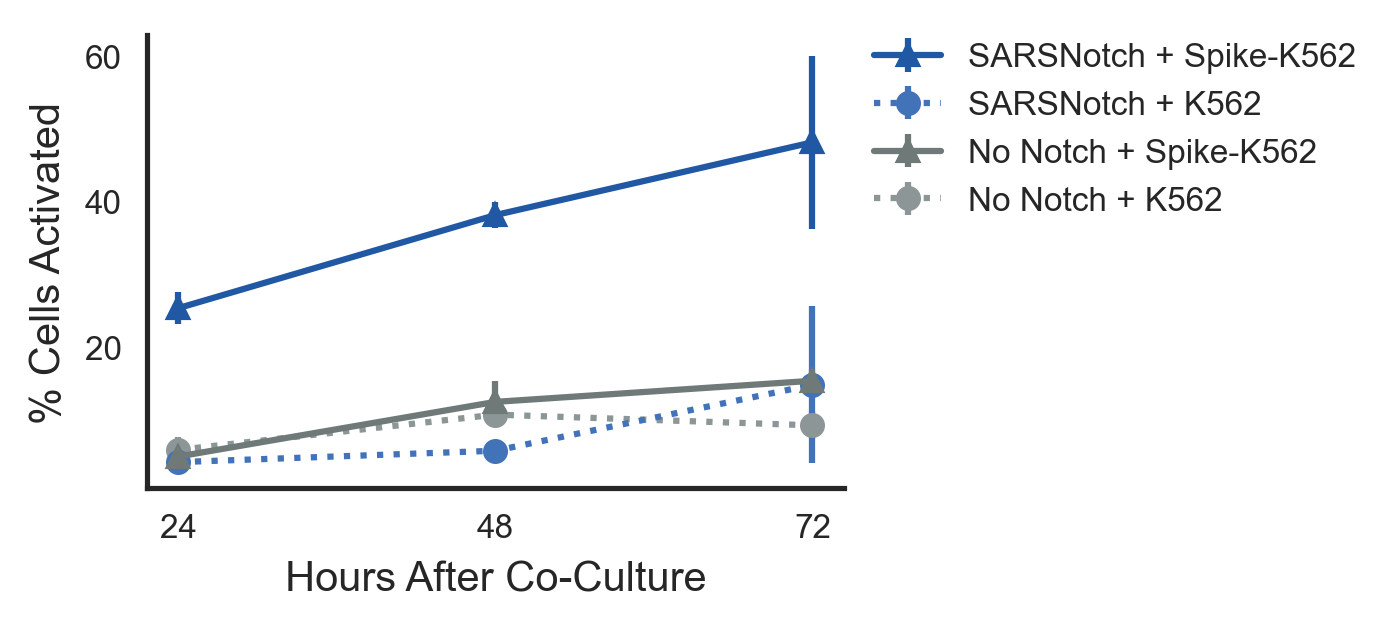

In [9]:
fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
for sender, receiver in product(senders, ['No Notch','SARSNotch']):
    condition_summary = df_summary[(df_summary['Receiver']==receiver) & 
                                   (df_summary['Sender']==sender) &
                                   (df_summary['Ratio'] == '1:1')]
    output = (condition_summary
              .groupby('Timepoint')['logBV 421-A']
              .agg([np.mean, np.std])
              .reset_index())
    ax.errorbar(output['Timepoint'], output['mean'], yerr=output['std'], 
                fmt='-', c=colors[receiver + ' + ' + sender], 
                label=f'{receiver} + {sender}',
                marker=markers[sender], markersize=5, ls=linestyles[sender])

ax.set_xlabel('Hours After Co-Culture')
ax.set_ylabel('% Cells Activated')
plt.legend()
handles, labels = ax.get_legend_handles_labels()
order = [3, 1, 2, 0]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(1,1.05))
sns.despine()
plt.savefig(outputdir + 'cell_cell_timecourse.svg')